Ahh, the dark art of hyperparameter tuning.
It's a key step in the machine learning workflow,
and it's an activity that can easily be overlooked or be overkill.
Therefore, dear reader, it is an art that requires the application of both skill and wisdom to realize its full potential while avoiding its perils.
Today I'll show you my approach for hyperparameter tuning XGBoost, although the principles apply to any GBT framework.
I'll give you some intuition for how to think about the key parameters in XGBoost,
and I'll show you an efficient strategy for parameter tuning GBTs.
I'll be using the optuna python library to tune parameters with bayesian optimization, but you can implement my strategy with whatever hyperparameter tuning utility you like.
You can download a notebook with this tuning workflow from my [data science templates repository](https://github.com/mcb00/ds-templates).
Finally we'll wrap up with the kind of cautionary tale data scientists tell their colleagues around the campfire about when all this fancy hyperparameter tuning can backfire catastrophically&mdash;ignore at your own peril.

![Lunar halo on a frosty night in Johnson City, TN](optuna_main.jpg "")

## XGBoost Parameters

Gradient boosting algorithms like XGBoost have two main types of hyperparameters: *tree parameters* which control the decision tree trained at each boosting round and *boosting parameters* which control the boosting procedure itself.
Below I'll highlight my favorite parameters, but you can see the full list in the [documentation](https://xgboost.readthedocs.io/en/stable/parameter.html).

### Tree Parameters
In theory you can use any kind of model as a base learner in a gradient boosting algorithm, but for reasons we discussed before, [decision trees](/posts/consider-the-decision-tree/) 
are typically the best choice.
In XGBoost, we can choose the tree construction algorithm, and we get three types of parameters to control its behavior: tree complexity parameters, sampling parameters, and regularization parameters.

#### Tree construction algorithm
The tree construction algorithm boils down to split finding, and
different algorithms have different ways of generating candidate splits to consider.
In XGBoost we have the parameter:

* `tree_method` - select tree construction algorithm: `exact`, `hist`,  `approx`, or the horrifying default&mdash;`auto`&mdash;which outsources your choice of tree construction algo to XGBoost and which you should never ever use.  I've been burned by this hidden `tree_method=auto` default multiple times before learning my lesson. Why is the online model worse than the offline model? Why is this model suddenly taking so much longer to train? Avoid these debugging nightmares and set `tree_method` explicitly; the exact method tends to be slow and ironically less accurate, so I use either approx or hist.

#### Tree complexity parameters
Tree complexity just means how many leaf nodes the trees have, and therefore how expressive they can be.
I use these two parameters:

* `max_depth` - maximum number of split levels allowed. Reasonable values are usually from 3-12.
* `min_child_weight` - minimum allowable sum of hessian values over data in a node. When using the default squared error objective, this is the minimum number of samples allowed in a leaf node (see [this explanation](https://stats.stackexchange.com/questions/317073/explanation-of-min-child-weight-in-xgboost-algorithm) of why that's true).
For a squared error objective, values in [1, 200] usually work well.

These two parameters oppose each other; increasing max depth allows for more expressive trees, while increasing  min child weight makes trees less expressive and therefore is a powerful way to counter overfitting.
Note that `gamma` (a.k.a. `min_split_loss`) also limits node splitting, but I usually don't use it because `min_child_weight` seems to work well enough on its own.

#### Sampling parameters
XGBoost can randomly sample rows and columns to be used for training each tree;
you might think of this as *bagging*.
We have a few parameters:

* `subsample` - proportion of rows to use in each tree. Setting this less than 1.0 results in stochastic gradient descent, because each tree is trained on only a subset of the entire training dataset. Any value in (0,1] is valid, but it seems like values in [0.7, 1] are usually the best.
* `colsample_bytree`, `colsample_bylevel`, `colsample_bynode` - control the fraction of columns available to each tree, at each split level, or at each split, respectively. I usually use either by level or by node because I like the idea that trees might be forced to learn interactions by having different features available at each subsequent split.  Again, values in (0,1] are valid, but values in [0.5,1] usually seem to work best.

#### Regularization parameters
In XGBoost, regularization penalizes the actual values predicted by the individual trees, pushing values toward zero.
I usually use:

* `reg_lambda` - L2 regularization  of tree predicted values. Increasing this parameter decreases tree expressiveness and therefore counters overfitting. 
Valid values are in [0,$\infty$), but good values typically fall in [0,10].

There is also an L1 regularization parameter called `reg_alpha`; feel free to use it instead.
It seems that using one or the other is usually sufficient.

### Boosting Parameters and Early Stopping
Trained gradient boosting models take the form:

$$ F(\mathbf{x}) = b + \eta \sum_{k=1}^{K} f_k(\mathbf{x}) $$ 

where $b$ is the constant base predicted value, $f_k(\cdot)$ is the base learner for round $k$, parameter $K$ is the number of boosting rounds, and parameter $\eta$ is the learning rate.
In XGBoost these parameters correspond with:

* `num_boost_round` ($K$) - the number of boosting iterations
* `learning_rate` ($\eta$) - the scaling or "shrinkage" factor applied to the predicted value of each base learner. Valid values are in (0,1]; the default is 0.3. Fun fact: the $\eta$ character is called "eta", and `learning_rate` is aliased to `eta` in xgboost, so you can use parameter `eta` instead of `learning_rate` if you like.

These two parameters are very closely linked; the optimal value of one depends on the value of the other.
To illustrate their relationship, we can train two different XGBoost models on the same training dataset, where one model has a lower learning rate than the other.

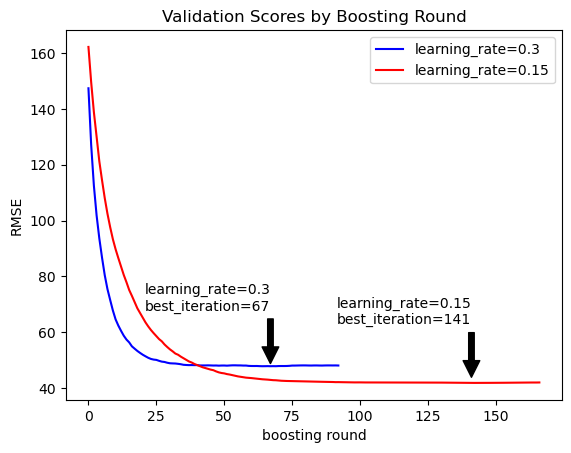

In [3]:
#| fig-cap: Hold-out validation score (RMSE) by boosting round for two XGBoost models differing only by learning rate.
#| fig-alt: XGBoost objective curves for two models
#| code-fold: true

import xgboost as xgb 
from sklearn.datasets import make_regression 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split 

X, y = make_regression(5000, random_state=0)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=0)

eta1, eta2 = 0.3, 0.15
reg1 = xgb.XGBRegressor(n_estimators=1000, learning_rate=eta1, early_stopping_rounds=25)
reg1.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_valid, y_valid)], 
        verbose=0);
reg2 = xgb.XGBRegressor(n_estimators=1000, learning_rate=eta2, early_stopping_rounds=25)
reg2.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_valid, y_valid)], 
        verbose=0);

fig, ax = plt.subplots()

best_round1, best_round2 = reg1.best_iteration, reg2.best_iteration
obj1 = reg1.evals_result()['validation_1']['rmse']
obj2 = reg2.evals_result()['validation_1']['rmse']
best_obj1 = obj1[best_round1]
best_obj2 = obj2[best_round1]

plt.plot(reg1.evals_result()['validation_1']['rmse'], '-b', label=f'learning_rate={eta1}')
plt.plot(reg2.evals_result()['validation_1']['rmse'], '-r', label=f'learning_rate={eta2}')
ax.annotate(f'learning_rate={eta1}\nbest_iteration={best_round1}', 
            xy=(best_round1, best_obj1), 
            xytext=(best_round1, best_obj1+20),
            horizontalalignment='right',
            arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate(f'learning_rate={eta2}\nbest_iteration={best_round2}', 
            xy=(best_round2, best_obj2), 
            xytext=(best_round2, best_obj2+20),
            horizontalalignment='right',
            arrowprops=dict(facecolor='black', shrink=0.05))
plt.legend()
plt.ylabel('RMSE') 
plt.xlabel('boosting round') 
plt.title('Validation Scores by Boosting Round');


The above figure shows root mean squared error measured on a held-out validation dataset for two different XGBoost models: one with a higher learning rate and one with a lower learning rate.
The figure demonstrates two key properties of the boosting parameters:

1. While training a model with a given learning rate, the evaluation score (computed on a hold-out set) tends to improve with additional boosting rounds up to a certain point, but beyond that point it flattens out or even gets worse.
1. All else constant, a smaller learning rate leads to a model with more boosting rounds and better  evaluation score.

We can leverage the first property to make our tuning more efficient by using XGBoost's `early_stopping_rounds: int` argument, which terminates training after observing the specified number of boosting rounds [without sufficient improvement](https://github.com/dmlc/xgboost/pull/6942)
to the evaluation metric.
The models above were trained using `early_stopping_rounds=50`, which terminates training after 50 boosting rounds without improvement in RMSE on the validation data.
For each model, the arrow indicates the boosting round with the best score.

The figure also exemplifies the second property, where the model with lower learning rate attains a better validation score but requires more boosting rounds to trigger early stopping.
Note that smaller and smaller learning rates will provide diminishing improvements to the validation score.


## An Efficient Parameter Search Strategy for XGBoost
Efficiency is the key to effective parameter tuning, because wasting less time means searching more  parameter values and finding better models in a given amount of time.
But as we just saw, there is a tradeoff between accuracy and training time via the learning rate.
Given infinite time and compute resources, we would just choose an arbitrarily tiny learning rate and search through tree parameter values while using early stopping to choose the number of boosting rounds.
The problem is that tiny learning rates require tons of boosting rounds, which will make our ideal search prohibitively slow when confronted with the reality of finite time and resources.
So what can we do?

My approach is based on the claim that
*good tree parameters at one learning rate are also good tree parameters at other learning rates*.
The intuition is that given two models&mdash;one with good tree parameters and one with bad tree parameters&mdash;the model with good tree parameters will score better, regardless of the learning rate.
Thus, tree parameters are "independent" of boosting parameters&mdash;See 
[this notebook](https://colab.research.google.com/drive/1feyrtDphFizVI1VmctrNgpJzonsmWiHx?usp=sharing) for justification of this claim.

Independence between tree parameters and boosting parameters suggests a two-stage procedure where we first find optimal tree parameters, then we maximize performance by pushing boosting parameters to the extreme.
The procedure is:

1. **Tune tree parameters.** Fix the learning rate at a relatively high value (like 0.3ish) and enable early stopping so that each model trains within a few seconds. Use your favorite hyperparameter tuning technique to find the optimal tree parameters.
1. **Tune boosting parameters.** Using these optimal tree parameter values, fix the learning rate as low as you want and train your model, using early stopping to identify the optimal number of boosting rounds.

Why is this a good idea? 
Because by starting with a high learning rate and early stopping enabled, you can burn through hundreds of model training trials and find some really good tree parameters in a few minutes.
Then, with the confidence that your tree parameters are actually quite good,  you can set a really low learning rate and boost a few thousand rounds to get a model with the best of both tree parameter and boosting parameter worlds.

> You can check out [this notebook](https://colab.research.google.com/drive/1feyrtDphFizVI1VmctrNgpJzonsmWiHx?usp=sharing)
where I justify this approach by running two parameter searches&mdash;one with high learning rate and one with low learning rate&mdash;showing that they recover the same optimal tree parameters.

## Tuning XGBoost Parameters with Optuna

[Optuna](https://optuna.readthedocs.io/en/stable/)
is a model-agnostic python library for hyperparameter tuning.
I like it because it has a flexible API that abstracts away the details of the search algorithm being used.
That means you can use this one library to tune all kinds of different models, and you can easily switch the parameter sampling approach among grid search, random search, the very sensible default bayesian optimization, and more.
Another massive benefit is that optuna provides a specific [XGBoost integration](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.integration.XGBoostPruningCallback.html) 
which terminates training early on lousy parameter combinations.

You can install optuna with anaconda, e.g.

```.zsh
$ conda install -c conda-forge optuna
```


## Example: Tuning the Bluebook for Bulldozers Regression Model

To illustrate the procedure, we'll tune the parameters for the regression model we built back in the [XGBoost for regression](/posts/xgboost-for-regression-in-python/) post.
First we'll load up the bulldozer data and prepare the features and target just like we did before.

In [4]:
#| code-fold: true
#| output: false
import time 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import optuna 

df = pd.read_csv('../xgboost-for-regression-in-python/Train.csv', parse_dates=['saledate']);

def encode_string_features(df):
    out_df = df.copy()
    for feature, feature_type in df.dtypes.items():
        if feature_type == 'object':
            out_df[feature] = out_df[feature].astype('category')
    return out_df

df = encode_string_features(df)

df['saledate_days_since_epoch'] = (
    df['saledate'] - pd.Timestamp(year=1970, month=1, day=1)
    ).dt.days

df['logSalePrice'] = np.log1p(df['SalePrice'])


features = [
    'SalesID',
    'MachineID',
    'ModelID',
    'datasource',
    'auctioneerID',
    'YearMade',
    'MachineHoursCurrentMeter',
    'UsageBand',
    'fiModelDesc',
    'fiBaseModel',
    'fiSecondaryDesc',
    'fiModelSeries',
    'fiModelDescriptor',
    'ProductSize',
    'fiProductClassDesc',
    'state',
    'ProductGroup',
    'ProductGroupDesc',
    'Drive_System',
    'Enclosure',
    'Forks',
    'Pad_Type',
    'Ride_Control',
    'Stick',
    'Transmission',
    'Turbocharged',
    'Blade_Extension',
    'Blade_Width',
    'Enclosure_Type',
    'Engine_Horsepower',
    'Hydraulics',
    'Pushblock',
    'Ripper',
    'Scarifier',
    'Tip_Control',
    'Tire_Size',
    'Coupler',
    'Coupler_System',
    'Grouser_Tracks',
    'Hydraulics_Flow',
    'Track_Type',
    'Undercarriage_Pad_Width',
    'Stick_Length',
    'Thumb',
    'Pattern_Changer',
    'Grouser_Type',
    'Backhoe_Mounting',
    'Blade_Type',
    'Travel_Controls',
    'Differential_Type',
    'Steering_Controls',
    'saledate_days_since_epoch'
 ]

target = 'logSalePrice'

/var/folders/p3/n6r4g5mj3m3dhls3j66tztmh0000gn/T/ipykernel_61627/2745696469.py:11: DtypeWarning: Columns (13,39,40,41) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../xgboost-for-regression-in-python/Train.csv', parse_dates=['saledate']);


But this time, since we're going to slam our validation set over and over during hyperparameter search, we want to reserve an actual test set to check how the final model generalizes.
We make four different `xgboost.DMatrix` datasets for this process: training, validation, training+validation, and test. 
Training and validation are for the parameter search, and training+validation and test are for the final model.

In [5]:
n_valid = 12000
n_test = 12000

sorted_df = df.sort_values(by='saledate')
train_df = sorted_df[:-(n_valid + n_test)] 
valid_df = sorted_df[-(n_valid + n_test):-n_test] 
test_df = sorted_df[-n_test:]

dtrain = xgb.DMatrix(data=train_df[features], label=train_df[target], 
                     enable_categorical=True)
dvalid = xgb.DMatrix(data=valid_df[features], label=valid_df[target], 
                     enable_categorical=True)
dtest = xgb.DMatrix(data=test_df[features], label=test_df[target], 
                    enable_categorical=True)
dtrainvalid = xgb.DMatrix(data=pd.concat([train_df, valid_df])[features], 
                          label=pd.concat([train_df, valid_df])[target], 
                          enable_categorical=True)

## Preliminaries: base parameters and scoring function

We'll go ahead and set a couple of parameters that we usually want to keep fixed across all trials in a parameter search, including the XGBoost objective for training and the evaluation metric to be used for early stopping.
We'll also want to implement a model scoring function that takes a trained model and a dataset and returns the score, in our case, RMSE.

In [6]:
metric = 'rmse'
base_params = {
    'objective': 'reg:squarederror',
    'eval_metric': metric,
}

In [7]:
def score_model(model: xgb.core.Booster, dmat: xgb.core.DMatrix) -> float:
    y_true = dmat.get_label() 
    y_pred = model.predict(dmat) 
    return mean_squared_error(y_true, y_pred, squared=False)

## Stage 1: Tune Tree Parameters with Optuna

Next we need to choose a fixed learning rate and tune the tree parameters.
We want a learning rate that allows us to train within a few seconds, so we need to time model training.
Start with a high learning rate (like 0.8) and work down until you find a rate that takes a few seconds.
Below I end up landing at 0.3, which takes about 4 seconds to train on my little laptop.

In [22]:
learning_rate = 0.3

params = {
    'tree_method': 'approx',
    'learning_rate': learning_rate
}
params.update(base_params)
tic = time.time()
model = xgb.train(params=params, dtrain=dtrain,
                  evals=[(dtrain, 'train'), (dvalid, 'valid')],
                  num_boost_round=10000,
                  early_stopping_rounds=50,
                  verbose_eval=0)
print(f'{time.time() - tic:.1f} seconds')


4.5 seconds


Then we implement our optuna objective, a function taking an optuna study [`Trial`](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.trial.Trial.html) 
object and returning the score we want to optimize.
We use the `suggest_categorical`, `suggest_float`, and `suggest_int` methods of the `Trial` object to define the search space for each parameter.
Note the use of the pruning callback function which we pass into the `callback` argument of the XGBoost `train` function; this is a must, since it allows optuna to terminate training on lousy models after a few boosting rounds.
After training a model with the selected parameter values, we stash the optimal number of boosting rounds from early stopping into an optuna user attribute using the [`trial.user_attrs()`](https://optuna.readthedocs.io/en/stable/tutorial/20_recipes/003_attributes.html) 
method. 
Finally we return the score computed by our `model_score` function.

In [23]:
def objective(trial):
    params = {
        'tree_method': trial.suggest_categorical('tree_method', ['approx', 'hist']),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 250),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'colsample_bynode': trial.suggest_float('colsample_bynode', 0.1, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.001, 25, log=True),
        'learning_rate': learning_rate,
    }
    num_boost_round = 10000
    params.update(base_params)
    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, f'valid-{metric}')
    model = xgb.train(params=params, dtrain=dtrain, num_boost_round=num_boost_round,
                      evals=[(dtrain, 'train'), (dvalid, 'valid')],
                      early_stopping_rounds=50,
                      verbose_eval=0,
                      callbacks=[pruning_callback])
    trial.set_user_attr('best_iteration', model.best_iteration)
    return model.best_score


To create a new optuna study and search through 50 parameter combinations, you could just run these two lines.

```python
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
```

But, in practice, I prefer to run these potentially long running tasks for a pre-specified amount of clock time, rather than a specified number of trials&mdash;who knows how long 50 trials will take.
I also want the results to be reproducible.
So, to set the random seed and run the optimization for around 300 seconds (long enough to go make a nice cup of tea, stretch,  and come back), I do something like this:

In [24]:
#| output: false
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction='minimize', sampler=sampler)
tic = time.time()
while time.time() - tic < 300:
    study.optimize(objective, n_trials=1)

[I 2023-12-25 10:56:44,240] A new study created in memory with name: no-name-c02dbf06-f9df-4d94-aabe-3e4aa3483743


[I 2023-12-25 10:56:54,971] Trial 0 finished with value: 0.24806856718849682 and parameters: {'tree_method': 'hist', 'max_depth': 10, 'min_child_weight': 150, 'subsample': 0.24041677639819287, 'colsample_bynode': 0.2403950683025824, 'reg_lambda': 0.001800728515054226}. Best is trial 0 with value: 0.24806856718849682.
[I 2023-12-25 10:57:01,291] Trial 1 finished with value: 0.23107522766919256 and parameters: {'tree_method': 'approx', 'max_depth': 10, 'min_child_weight': 6, 'subsample': 0.9729188669457949, 'colsample_bynode': 0.8491983767203796, 'reg_lambda': 0.008587261143813469}. Best is trial 1 with value: 0.23107522766919256.
[I 2023-12-25 10:57:14,861] Trial 2 finished with value: 0.23580702157545438 and parameters: {'tree_method': 'hist', 'max_depth': 6, 'min_child_weight': 132, 'subsample': 0.48875051677790415, 'colsample_bynode': 0.36210622617823773, 'reg_lambda': 0.4907861801695248}. Best is trial 1 with value: 0.23107522766919256.
[I 2023-12-25 10:57:25,068] Trial 3 finished w

In [26]:
#| code-fold: true
print('Stage 1 ==============================')
print(f'best score = {study.best_trial.value}')
print('boosting params ---------------------------')
print(f'fixed learning rate: {learning_rate}')
print(f'best boosting round: {study.best_trial.user_attrs["best_iteration"]}')
print('best tree params --------------------------')
for k, v in study.best_trial.params.items():
    print(k, ':', v)

Stage 1 ==============================
best score = 0.23107522766919256
boosting params ---------------------------
fixed learning rate: 0.3
best boosting round: 23
best tree params --------------------------
tree_method : approx
max_depth : 10
min_child_weight : 6
subsample : 0.9729188669457949
colsample_bynode : 0.8491983767203796
reg_lambda : 0.008587261143813469


If we decide we want to tune the tree parameters a little more, we can just call `study.optimize(...)` again, adding as many trials as we want to the study.
Once we're happy with the tree parameters, we can proceed to stage 2.

## Stage 2: Intensify the Boosting Parameters

Now we take the optimal tree parameters that we found in stage 1, and we train a new model with a fixed low learning rate; here I use 0.01, but you could go lower.
The lower your learning rate, the better your performance (with diminishing returns) and the more boosting rounds you'll need to max out the evaluation metric on the validation data.

In [27]:
#| output: false
low_learning_rate = 0.01

params = {}
params.update(base_params)
params.update(study.best_trial.params)
params['learning_rate'] = low_learning_rate
model_stage2 = xgb.train(params=params, dtrain=dtrain, 
                         num_boost_round=10000,
                         evals=[(dtrain, 'train'), (dvalid, 'valid')],
                         early_stopping_rounds=50,
                         verbose_eval=0)

In [28]:
#| code-fold: true
print('Stage 2 ==============================')
print(f'best score = {score_model(model_stage2, dvalid)}')
print('boosting params ---------------------------')
print(f'fixed learning rate: {params["learning_rate"]}')
print(f'best boosting round: {model_stage2.best_iteration}')

Stage 2 ==============================


best score = 0.22172991931438446
boosting params ---------------------------
fixed learning rate: 0.01
best boosting round: 1446


## Train and Evaluate the Final Model

Now we can train our final model on the combined training and validation datasets using the optimal tree parameters from stage 1 and the fixed learning rate and optimal boosting rounds from stage 2.
Then we evaluate on the held out test data.

In [29]:
#| output: false
model_final = xgb.train(params=params, dtrain=dtrainvalid, 
                        num_boost_round=model_stage2.best_iteration,
                        verbose_eval=0)

In [30]:
#| code-fold: true
print('Final Model ==========================')
print(f'test score = {score_model(model_final, dtest)}')
print('parameters ---------------------------')
for k, v in params.items():
    print(k, ':', v)
print(f'num_boost_round: {model_stage2.best_iteration}')

Final Model ==========================
test score = 0.21621863543987274
parameters ---------------------------
objective : reg:squarederror
eval_metric : rmse
tree_method : approx
max_depth : 10
min_child_weight : 6
subsample : 0.9729188669457949
colsample_bynode : 0.8491983767203796
reg_lambda : 0.008587261143813469
learning_rate : 0.01
num_boost_round: 1446


Back in the [regression post](/posts/xgboost-for-regression-in-python/) 
we got an RMSE of about 0.231 just using default parameter values, which put us in 5th place on the [leaderboard for the Kagle dozers competition](https://www.kaggle.com/competitions/bluebook-for-bulldozers/leaderboard).
Now with about 10 minutes of hyperparameter tuning, our RMSE is down to 0.216 which puts us in 1st place by a huge margin. 🙌

## What could possibly go wrong?

Hyperparameter tuning can easily be overlooked in the move-fast-and-break-everything hustle of building an ML product, but it can also easily become overkill or even downright harmful, depending on the application.
There are three key questions to ask:

1. How much value is created by an incremental gain in model prediction accuracy?
1. What is the cost of increasing model prediction accuracy?
1. Is my model answering the right question?

Sometimes a small gain in model prediction performance translates into millions of dollars of impact.
The dream scenario is that you swoop in on some key model in your organization, markedly improve its accuracy with an easy afternoon of hyperparameter tuning, realize massive improvements in your org's KPIs, and get mad respect, bonuses, and promoted.
But the reality is that often additional model accuracy doesn't really change business KPIs by very much.
Try to figure out the actual value of improved model accuracy and proceed accordingly.

Remember too that hyperparameter tuning has its costs, most obviously the developer time and compute resources for the search itself.
It can also lead us to larger and deeper models which take longer to train, occupy larger memory footprints, and have higher prediction latency.

Worst of all and quite counterintuitively, it's possible that improving a model's prediction accuracy can compromise overall business KPIs.
I've seen this with my own eyes at work;
offline testing shows that hyperparameter tuning significantly improves a model's prediction accuracy, but when the model goes into production, an AB test shows that the business KPIs are actually worse.
What happened?
In this case, the model's prediction was being used indirectly to infer the relationship between one of the features and the prediction target to inform automatic business decisions.
Answering questions about how changing an input will affect an output requires causal reasoning, and [traditional ML models are not the right tool for the job](https://arxiv.org/abs/1608.00060).
I'll have a lot more to say about that soon;
let this story foreshadow an epic new epoch on Random Realizations....

## Wrapping Up

There it is, an efficient and ridiculously easy hyperparameter tuning strategy for XGBoost using optuna.
If you found this helpful, if you have questions, or if you have your own preferred method for parameter search, let me know about it down in the comments!